In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix,make_scorer
from sklearn.utils import resample
from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
import category_encoders as ce
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier

from catboost import Pool,CatBoostClassifier

warnings.filterwarnings('ignore')

In [2]:
df_matches = pd.read_csv('matches.csv',header=0)
df_matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [3]:
df_matches.columns

Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')

### Fixing the dataset

In [4]:
df_matches['venue'][df_matches.venue == 'M. Chinnaswamy Stadium'] = 'M Chinnaswamy Stadium'
df_matches['city'][df_matches.city.isin(['Bangalore','Bengaluru'])] = 'Bangalore/Bengaluru'
df_matches['venue'][df_matches.venue == 'M. A. Chidambaram Stadium'] = 'MA Chidambaram Stadium, Chepauk'

#### Player with most Man of the matches

In [5]:
mom_data = df_matches.groupby('player_of_match',as_index=False)['id'].count().sort_values('id',ascending=False)
mom_data.head(10)

,player_of_match,id
35,CH Gayle,21
10,AB de Villiers,20
137,MS Dhoni,17
42,DA Warner,17
167,RG Sharma,17
222,YK Pathan,16
201,SR Watson,15
191,SK Raina,14
56,G Gambhir,13
123,MEK Hussey,12


### Team winning batting 1st or 2nd? in each ground

In [6]:
field_win = df_matches[df_matches['win_by_runs'] == 0].groupby(['city','venue'],as_index=False)['id'].count()
field_win.rename(columns={'id':'Fielding First Win Count'},inplace=True)
bat_win = df_matches[df_matches['win_by_runs'] > 0].groupby(['city','venue'],as_index=False)['id'].count()
bat_win.rename(columns={'id':'Batting First Win Count'},inplace=True)
ground_win = field_win.set_index(['city','venue']).join(bat_win.set_index(['city','venue']))
ground_win['Diff'] = ground_win['Batting First Win Count'] - ground_win['Fielding First Win Count']
ground_win.sort_values(by='Diff',ascending=False).fillna(0).head()

,,Fielding First Win Count,Batting First Win Count,Diff
city,venue,,,
Chennai,"MA Chidambaram Stadium, Chepauk",23,34.0,11.0
Pune,Subrata Roy Sahara Stadium,6,11.0,5.0
Durban,Kingsmead,6,9.0,3.0
Visakhapatnam,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,4,7.0,3.0
Hyderabad,Rajiv Gandhi Intl. Cricket Stadium,3,5.0,2.0


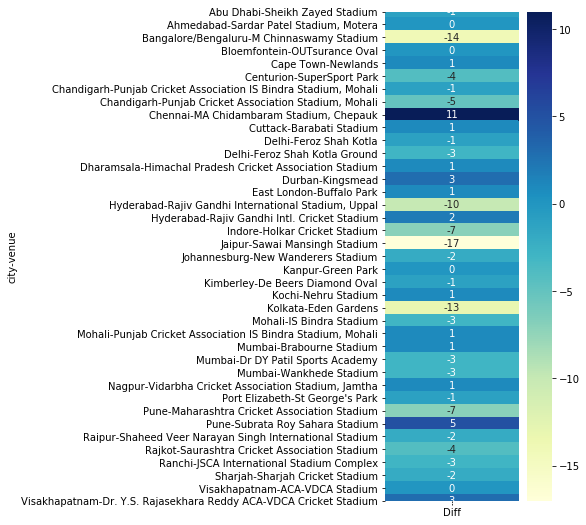

In [7]:
plotter=ground_win.reset_index()
plotter = plotter[['city','venue','Diff']].fillna(0)
plotter.set_index(['city','venue'],inplace=True)
plt.figure(figsize=(3,9))
sns.heatmap(plotter,annot=True,cmap="YlGnBu")
plt.show()

We can see teams batting first win in Chennai and Pune but teams batting second win in Kolkata, Jaipur, and Bangalore

#### Team favouring ground

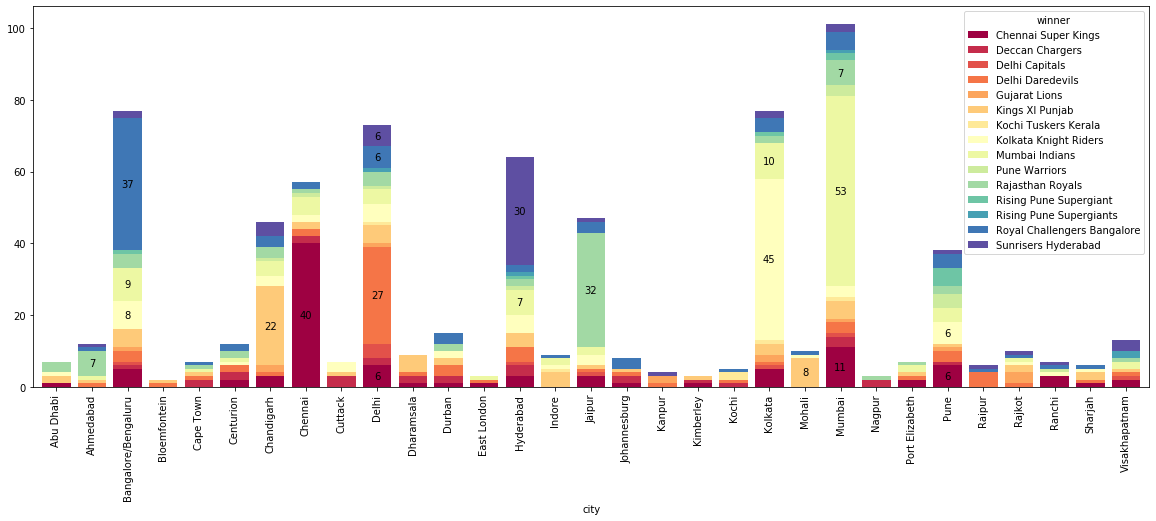

In [8]:
ground_winner = df_matches.groupby(['city','winner'])['id'].count().unstack('winner').fillna(0)
cmap = cm.get_cmap('Spectral')
ax = ground_winner.plot(kind='bar',stacked=True,figsize=(20,7),width=0.8,colormap=cmap)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height>5:
        ax.text(x+width/2, 
            y+height/2, 
            int(height), 
            horizontalalignment='center', 
            verticalalignment='center')

All the teams are favoring thier homegrounds, There is a near equal fight in Pune. 

In [9]:
df_balls = pd.read_csv('deliveries.csv',header=0)
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [10]:
df_balls.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [11]:
df_balls.shape

(179078, 21)

In [96]:
df_balls['dismissal_kind'][df_balls['dismissal_kind'].isna()] = 'NA'
df_balls['player_dismissed'][df_balls['player_dismissed'].isna()] = 'NA'
df_balls['fielder'][df_balls['fielder'].isna()] = 'NA'
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,fielder,bowler_runs_conceded,wickets_fallen,score,last_wicket_ball,striker_runs,non_striker_runs,bowler_match_runs,bowler_match_wickets,is_wicket
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,1
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,1
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,NA,4,0,4,0.0,4,0,4,0,1
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,4,0.0,4,0,4,0,1
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,NA,2,0,6,0.0,4,0,6,0,1


In [13]:
df_balls.describe()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
count,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000
mean,1802.252957,1.482952,10.162488,3.615587,0.000452,0.036721,0.004936,0.021136,0.004183,0.000056,1.246864,0.067032,1.313897
std,3472.322805,0.502074,5.677684,1.806966,0.021263,0.251161,0.116480,0.194908,0.070492,0.016709,1.608270,0.342553,1.605422
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,190.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,379.000000,1.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,567.000000,2.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,11415.000000,5.000000,20.000000,9.000000,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,7.000000,7.000000,10.000000


In [14]:
player_runs = df_balls.groupby('batsman',as_index=False)['batsman_runs'].sum()
player_runs.sort_values(by=['batsman_runs'],ascending=False,inplace=True)
player_matches = df_balls.groupby('batsman',as_index=False).agg({'match_id': pd.Series.nunique})
player_matches.sort_values(by=['match_id'],ascending=False,inplace=True)
player_matches.head()

,batsman,match_id
428,SK Raina,189
367,RG Sharma,182
384,RV Uthappa,170
290,MS Dhoni,170
486,V Kohli,169


## Dataframe containing batsman data

In [15]:
player_data = player_runs.merge(player_matches,on=['batsman'])
player_data.rename(columns={'match_id':'matches'},inplace=True)
#mom_data.rename(columns={'player_of_match':'batsman','id':'MOM Wins'},inplace=True)
player_data = player_data.merge(mom_data.rename(columns={'player_of_match':'batsman','id':'MOM Wins'}),on=['batsman'])
player_data['average'] = player_data.batsman_runs/player_data.matches
player_data.sort_values(by=['batsman_runs'],inplace=True,ascending=False)
player_data.head(10)

,batsman,batsman_runs,matches,MOM Wins,average
0,V Kohli,5434,169,12,32.153846
1,SK Raina,5415,189,14,28.650794
2,RG Sharma,4914,182,17,27.000000
3,DA Warner,4741,126,17,37.626984
4,S Dhawan,4632,158,6,29.316456
5,CH Gayle,4560,124,21,36.774194
6,MS Dhoni,4477,170,17,26.335294
7,RV Uthappa,4446,170,7,26.152941
8,AB de Villiers,4428,142,20,31.183099
9,G Gambhir,4223,151,13,27.966887


In [16]:
batsman_balls = df_balls[df_balls.wide_runs == 0].groupby('batsman',as_index=False)['ball'].count()
batsman_balls.rename(columns={'ball':'balls_faced'},inplace=True)
player_data = player_data.merge(batsman_balls,on=['batsman'])
player_data['strk_rate'] = 100*(player_data['batsman_runs']/player_data['balls_faced'])
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


In [17]:
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


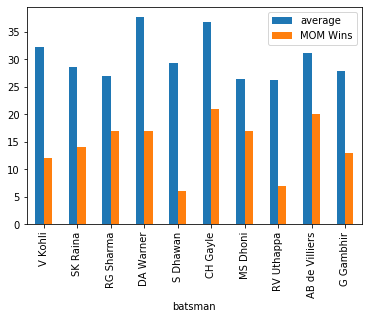

In [18]:
top_10_batsman = player_data.head(10).set_index('batsman')
ax = top_10_batsman[['average','MOM Wins']].plot.bar()

In [19]:
player_matches[player_matches.batsman == 'SL Malinga']

,batsman,match_id
431,SL Malinga,20


### Dataframe containing bowler data

In [20]:
player_wickets = df_balls[(df_balls.player_dismissed.notna()) & 
                          (~df_balls['dismissal_kind'].isin(
                              ['NA','run out', 'retired hurt', 'obstructing the field']))].groupby('bowler',as_index=False)['player_dismissed'].count()
player_matches = df_balls.groupby('bowler',as_index=False).agg({'match_id': pd.Series.nunique})
player_wickets = player_wickets.merge(player_matches.rename(columns={'match_id':'matches'}),on='bowler')
df_balls['bowler_runs_conceded'] = df_balls.wide_runs + df_balls.noball_runs + df_balls.penalty_runs + df_balls.batsman_runs
player_runs = df_balls.groupby('bowler',as_index=False)['bowler_runs_conceded'].sum()
bowler_data = player_wickets.merge(player_runs[['bowler','bowler_runs_conceded']],on='bowler')
bowler_data['average'] = bowler_data.bowler_runs_conceded/bowler_data.player_dismissed
bowler_data = bowler_data.merge(mom_data.rename(columns={'player_of_match':'bowler','id':'MOM Wins'}),on=['bowler'])
bowler_data.rename(columns={'player_dismissed':'wickets_taken'},inplace=True)
top_10_bowlers = bowler_data.sort_values(by='wickets_taken',ascending=False).head(10)
top_10_bowlers

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins
137,SL Malinga,170,122,3395,19.970588,6
3,A Mishra,156,147,3804,24.384615,11
50,Harbhajan Singh,150,157,3979,26.526667,8
111,PP Chawla,149,156,4086,27.422819,3
35,DJ Bravo,147,131,3662,24.911565,3
20,B Kumar,133,117,3185,23.947368,5
114,R Ashwin,125,136,3337,26.696000,2
139,SP Narine,122,109,2884,23.639344,9
150,UT Yadav,119,118,3550,29.831933,8
119,RA Jadeja,108,142,3176,29.407407,8


In [21]:
bowler_balls = df_balls[(df_balls.wide_runs == 0) & (df_balls.noball_runs == 0)].groupby('bowler',as_index=False)['ball'].count()
bowler_balls.rename(columns={'ball':'balls_bowled'},inplace=True)
bowler_data = bowler_data.merge(bowler_balls,on=['bowler'])
bowler_data['bowler_strk_rate'] = (bowler_data['balls_bowled']/bowler_data['wickets_taken'])
bowler_data.head()

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins,balls_bowled,bowler_strk_rate
0,A Chandila,11,12,242,22.000000,1,234,21.272727
1,A Joseph,6,3,92,15.333333,1,52,8.666667
2,A Kumble,45,42,1058,23.511111,3,965,21.444444
3,A Mishra,156,147,3804,24.384615,11,3102,19.884615
4,A Nehra,106,88,2495,23.537736,6,1908,18.000000


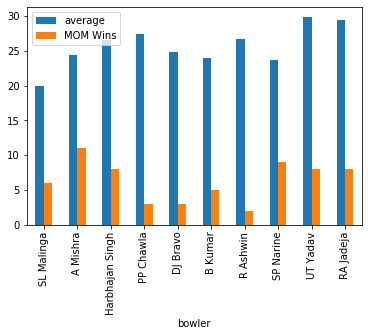

In [22]:
ax = top_10_bowlers.set_index('bowler')[['average','MOM Wins']].plot.bar()

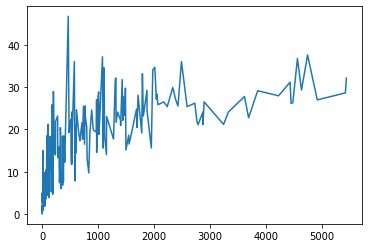

In [23]:
plt.plot(player_data.batsman_runs,player_data.average)

## Lets predict what will happen on each ball

In [24]:
df_balls.shape

(179078, 22)

#### We need to add some columns like - Bowler data, Batsman data, Wickets Fallen, Score, Last Wicket Fallen Over, Average Total at venue 

##### Adding column 'wickets_fallen' ,'score','last_wicket_ball','striker_runs','non_striker_runs','bowler_match_runs' and 'bowler_match_wickets' ====need to find better way

In [ ]:
df_balls.sort_values(by=['match_id','inning','over','ball'])

df_balls['wickets_fallen'] = 0
wick = 0

df_balls['score'] = 0
sc = 0

df_balls['last_wicket_ball'] = 0.0
lb = 0.0

df_balls['striker_runs'] = 0
df_balls['non_striker_runs'] = 0
bruns = 0
nsruns = 0

df_balls['bowler_match_runs'] = 0
bowler_match_runs = 0
k = 0

df_balls['bowler_match_wickets'] = 0
bowler_match_wicks = 0
k1 = 0

for i,row in df_balls.iterrows():
    if i > 0:
        match = row['match_id']
        inning = row['inning']
        last_index = i - 1
        if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
            
            #for wickets_fallen and last_wicket_ball
            if row['player_dismissed'] != 'NA':
                wick = 1
                lb = 1.1
            else:
                wick = 0
                lb = 0.0
            
            df_balls['wickets_fallen'][i] = wick
            df_balls['last_wicket_ball'][i] = lb
            
            #for score    
            sc = 0
            df_balls['score'][i] = sc
            
            #for batsman_runs
            if row['batsman_runs'] > 0:
                bruns += row['batsman_runs']
            df_balls['striker_runs'][i] = bruns
            df_balls['non_striker_runs'][i] = nsruns
            
            #for bowler_match_runs
            bowler_match_runs = row['bowler_runs_conceded']
            df_balls['bowler_match_runs'][i] = bowler_match_runs
            k = i
            
            bowler_match_wicks = 0
            if row['player_dismissed'] != 'NA':
                bowler_match_wicks = 1                      
            df_balls['bowler_match_wickets'][i] = bowler_match_wicks
            k1 = i
            
            continue
        
        #for wickets_fallen
        if (row['player_dismissed'] != 'NA'):
            wick += 1
            lb = row['over'] + (0.1)*(row['ball'])    
        
        df_balls['wickets_fallen'][i] = wick
        df_balls['last_wicket_ball'][i] = lb
        
        #for score
        sc += row['total_runs']
        df_balls['score'][i] = sc
        
        #for striker_runs and non_striker_runs
        last_ball_bat = df_balls['batsman'][last_index]
        last_ball_ns = df_balls['non_striker'][last_index]
        new_ball_bat = row['batsman']
        new_ball_ns = row['non_striker']
        
        if (last_ball_bat == new_ball_ns) & (last_ball_ns == new_ball_bat):
            temp = bruns
            bruns = nsruns
            nsruns = temp
        elif (last_ball_bat != new_ball_ns) & (last_ball_ns == new_ball_bat):
            bruns = nsruns
            nsruns = 0
        elif (last_ball_bat == new_ball_ns) & (last_ball_ns != new_ball_bat):
            nsruns = bruns
            bruns = 0
        elif (last_ball_bat == new_ball_bat) & (last_ball_ns != new_ball_ns):
            nsruns = 0
        elif (last_ball_bat != new_ball_bat) & (last_ball_ns == new_ball_ns):
            bruns = 0
        
        bruns += row['batsman_runs']
        df_balls['striker_runs'][i] = bruns
        df_balls['non_striker_runs'][i] = nsruns
        
        
        #for bowler_match_runs
        checker = df_balls.iloc[k:i+1,:].groupby('bowler',as_index=False)['bowler_runs_conceded'].sum()
        bowler_match_runs = checker[checker['bowler'] == row['bowler']]
        df_balls['bowler_match_runs'][i] = bowler_match_runs['bowler_runs_conceded'].values[0]
        
        
        #for bowler_match_wickets
        player_wickets_checker = df_balls.iloc[k1:i+1,:][~df_balls['dismissal_kind'].isin(
                              ['NA','run out', 'retired hurt','obstructing the field'])
                         ].groupby('bowler',as_index=False)['player_dismissed'].count()
        bowler_match_wicks = player_wickets_checker[player_wickets_checker['bowler'] == row['bowler']]
        if bowler_match_wicks['player_dismissed'].values:
            df_balls['bowler_match_wickets'][i] = bowler_match_wicks['player_dismissed'].values[0]
        else:
            df_balls['bowler_match_wickets'][i] = 0
        
        if i%10000 == 0:
            print(i,' Done')
        
    else:
        if row['player_dismissed'] != 'NA':
            wick = 1
            lb = 1.1
            bruns = 0
        
        df_balls['last_wicket_ball'][i] = lb
        df_balls['wickets_fallen'][i] = wick
        
        #for score
        sc += row['total_runs']
        df_balls['score'][i] = sc
        
        #for batsman_runs
        if row['batsman_runs'] > 0:
            bruns += row['batsman_runs']
        df_balls['striker_runs'][i] = bruns
        df_balls['non_striker_runs'][i] = nsruns
        
        #for bowler_match_runs
        df_balls['bowler_match_runs'][i] = bowler_match_runs
        
        #for bowler_match_wickets
        df_balls['bowler_match_wickets'][i] = bowler_match_wicks

df_balls.head()

##### Adding column 'score' need to find better way

In [ ]:
# df_balls['score'] = 0
# sc = 0
# for i,row in df_balls.iterrows():
#     if i > 0:
#         match = row['match_id']
#         inning = row['inning']
#         last_index = i - 1
#         if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
#             sc = 0
#             df_balls['score'][i] = sc
#         else:
#             sc += row['total_runs']
#             df_balls['score'][i] = sc
#     else:
#         sc += row['total_runs']
#         df_balls['score'][i] = sc
# df_balls.head()

##### Adding column 'last_wicket_ball' need to find better way

In [ ]:
# df_balls['last_wicket_ball'] = 0.0
# lb = 0.0
# for i,row in df_balls.iterrows():
#     if i > 0:
#         match = row['match_id']
#         inning = row['inning']
#         last_index = i - 1
#         if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
#             if row['player_dismissed'] != 'NA':
#                 lb = 1.1
#                 df_balls['last_wicket_ball'][i] = lb
#             else:
#                 lb = 0.0
#                 df_balls['last_wicket_ball'][i] = lb
#             continue
        
#         if (row['player_dismissed'] != 'NA'):
#             lb = row['over'] + (0.1)*(row['ball'])
#             df_balls['last_wicket_ball'][i] = lb
#         else:
#             df_balls['last_wicket_ball'][i] = lb
#     else:
#         if row['player_dismissed'] != 'NA':
#             lb = 1.1
#             df_balls['last_wicket_ball'][i] = lb
# df_balls.head()

#### Adding columns 'striker_runs' and 'non_striker_runs'

In [ ]:
# df_balls['striker_runs'] = 0
# df_balls['non_striker_runs'] = 0
# bruns = 0
# nsruns = 0
# for i,row in df_balls.iterrows():
#     if i > 0:
#         match = row['match_id']
#         inning = row['inning']
#         last_index = i - 1
#         if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
#             if row['batsman_runs'] > 0:
#                 bruns += row['batsman_runs']
#             df_balls['striker_runs'][i] = bruns
#             df_balls['non_striker_runs'][i] = nsruns
#             continue
        
#         last_ball_bat = df_balls['batsman'][last_index]
#         last_ball_ns = df_balls['non_striker'][last_index]
#         new_ball_bat = row['batsman']
#         new_ball_ns = row['non_striker']
        
        
        
#         if (last_ball_bat == new_ball_ns) & (last_ball_ns == new_ball_bat):
#             temp = bruns
#             bruns = nsruns
#             nsruns = temp
#         elif (last_ball_bat != new_ball_ns) & (last_ball_ns == new_ball_bat):
#             bruns = nsruns
#             nsruns = 0
#         elif (last_ball_bat == new_ball_ns) & (last_ball_ns != new_ball_bat):
#             nsruns = bruns
#             bruns = 0
#         elif (last_ball_bat == new_ball_bat) & (last_ball_ns != new_ball_ns):
#             nsruns = 0
#         elif (last_ball_bat != new_ball_bat) & (last_ball_ns == new_ball_ns):
#             bruns = 0
        
#         bruns += row['batsman_runs']
#         df_balls['striker_runs'][i] = bruns
#         df_balls['non_striker_runs'][i] = nsruns
        
#     else:
#         if row['player_dismissed'] != 'NA':
#             bruns = 0
#         if row['batsman_runs'] > 0:
#             bruns += row['batsman_runs']
#         df_balls['striker_runs'][i] = bruns
#         df_balls['non_striker_runs'][i] = nsruns
        
# df_balls.head()

#### Adding columns 'bowler_match_runs' and 'bowler_match_wickets'

In [116]:
# df_balls['bowler_match_runs'] = 0
# bowler_match_runs = 0
# k = 0
# for i,row in df_balls.iterrows():
#     if i > 0:
#         match = row['match_id']
#         inning = row['inning']
#         last_index = i - 1
#         if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
#             bowler_match_runs = row['bowler_runs_conceded']
#             df_balls['bowler_match_runs'][i] = bowler_match_runs
#             k = i
#             continue
        
#         checker = df_balls.iloc[k:i+1,:].groupby('bowler',as_index=False)['bowler_runs_conceded'].sum()
#         bowler_match_runs = checker[checker['bowler'] == row['bowler']]
#         df_balls['bowler_match_runs'][i] = bowler_match_runs['bowler_runs_conceded'].values[0]
        
#         if i%10000 == 0:
#             print(i,' Done')
#     else:
#         df_balls['bowler_match_runs'][i] = bowler_match_runs


In [12]:
df_balls['dismissal_kind'].unique()

array(['NA', 'caught', 'bowled', 'run out', 'lbw', 'caught and bowled',
       'stumped', 'retired hurt', 'hit wicket', 'obstructing the field'],
      dtype=object)

In [21]:
# df_balls['bowler_match_wickets'] = 0
# bowler_match_wicks = 0
# k = 0
# for i,row in df_balls.iterrows():
#     if i > 0:
#         match = row['match_id']
#         inning = row['inning']
#         last_index = i - 1
#         if (df_balls['match_id'][last_index] != match) or (df_balls['inning'][last_index] != inning):
#             bowler_match_wicks = 0
#             if row['player_dismissed'] != 'NA':
#                 bowler_match_wicks = 1                      
#             df_balls['bowler_match_wickets'][i] = bowler_match_wicks
#             k = i
#             continue
        
#         player_wickets_checker = df_balls.iloc[k:i+1,:][~df_balls['dismissal_kind'].isin(
#                               ['NA','run out', 'retired hurt','obstructing the field'])
#                          ].groupby('bowler',as_index=False)['player_dismissed'].count()
#         bowler_match_wicks = player_wickets_checker[player_wickets_checker['bowler'] == row['bowler']]
#         if bowler_match_wicks['player_dismissed'].values:
#             df_balls['bowler_match_wickets'][i] = bowler_match_wicks['player_dismissed'].values[0]
#         else:
#             df_balls['bowler_match_wickets'][i] = 0
        
#         if i%10000 == 0:
#             print(i,' Done')
#     else:
#         df_balls['bowler_match_wickets'][i] = bowler_match_wicks


10000  Done
20000  Done
30000  Done
40000  Done
50000  Done
60000  Done
70000  Done
80000  Done
90000  Done
100000  Done
110000  Done
120000  Done
130000  Done
140000  Done
150000  Done
160000  Done
170000  Done


###### Saving the hard work

In [23]:
export_balls = df_balls.to_csv('df_balls.csv', index = None, header=True)

In [24]:
df_balls = pd.read_csv('df_balls.csv',header=0)
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,dismissal_kind,fielder,bowler_runs_conceded,wickets_fallen,score,last_wicket_ball,striker_runs,non_striker_runs,bowler_match_runs,bowler_match_wickets
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,0,0.0,0,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,0,0.0,0,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,4,0,4,0.0,4,0,4,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,4,0.0,4,0,4,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,2,0,6,0.0,4,0,6,0


In [25]:
allplayers = list(df_balls['batsman'].unique()) + list(df_balls['bowler'].unique()) + list(df_balls['non_striker'].unique())
allplayers_unique = set(allplayers)
allplayers_unique

{'A Ashish Reddy',
 'A Chandila',
 'A Chopra',
 'A Choudhary',
 'A Dananjaya',
 'A Flintoff',
 'A Hales',
 'A Joseph',
 'A Kumble',
 'A Mishra',
 'A Mithun',
 'A Mukund',
 'A Nehra',
 'A Nel',
 'A Roy',
 'A Singh',
 'A Symonds',
 'A Turner',
 'A Uniyal',
 'A Zampa',
 'AA Bilakhia',
 'AA Chavan',
 'AA Jhunjhunwala',
 'AA Kazi',
 'AA Noffke',
 'AB Agarkar',
 'AB Barath',
 'AB Dinda',
 'AB McDonald',
 'AB de Villiers',
 'AC Blizzard',
 'AC Gilchrist',
 'AC Thomas',
 'AC Voges',
 'AD Mascarenhas',
 'AD Mathews',
 'AD Nath',
 'AD Russell',
 'AF Milne',
 'AG Murtaza',
 'AG Paunikar',
 'AJ Finch',
 'AJ Tye',
 'AL Menaria',
 'AM Nayar',
 'AM Rahane',
 'AM Salvi',
 'AN Ahmed',
 'AN Ghosh',
 'AP Dole',
 'AP Majumdar',
 'AP Tare',
 'AR Bawne',
 'AR Patel',
 'AS Rajpoot',
 'AS Raut',
 'AS Yadav',
 'AT Rayudu',
 'AUK Pathan',
 'Abdur Razzak',
 'Anand Rajan',
 'Anirudh Singh',
 'Ankit Sharma',
 'Ankit Soni',
 'Anureet Singh',
 'Avesh Khan',
 'Azhar Mahmood',
 'B Akhil',
 'B Chipli',
 'B Geeves',
 'B

In [26]:
allteams = list(df_balls['batting_team'].unique()) + list(df_balls['bowling_team'].unique())
allteams_unique = set(allteams)
allteams_unique

{'Chennai Super Kings',
 'Deccan Chargers',
 'Delhi Capitals',
 'Delhi Daredevils',
 'Gujarat Lions',
 'Kings XI Punjab',
 'Kochi Tuskers Kerala',
 'Kolkata Knight Riders',
 'Mumbai Indians',
 'Pune Warriors',
 'Rajasthan Royals',
 'Rising Pune Supergiant',
 'Rising Pune Supergiants',
 'Royal Challengers Bangalore',
 'Sunrisers Hyderabad'}

### Dataframe df_balls_matches preparation start for prediction

In [27]:
df_balls_matches = df_balls.merge(df_matches,left_on='match_id',right_on='id')
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder', 'bowler_runs_conceded', 'wickets_fallen',
       'score', 'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'date', 'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'winner', 'win_by_runs', 'win_by_wickets',
       'player_of_match', 'venue', 'umpire1', 'umpire2', 'umpire3'],
      dtype='object')

In [28]:
df_balls_matches = df_balls_matches.drop(['umpire1', 'umpire2', 'umpire3','date','dismissal_kind', 'fielder', 
                                          'bowler_runs_conceded','winner', 'win_by_runs', 'win_by_wickets',
       'player_of_match'],axis=1)
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'wickets_fallen', 'score', 'last_wicket_ball', 'striker_runs',
       'non_striker_runs', 'bowler_match_runs', 'bowler_match_wickets', 'id',
       'season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'result', 'dl_applied', 'venue'],
      dtype='object')

In [29]:
bowler_data.head()

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins,balls_bowled,bowler_strk_rate
0,A Chandila,11,12,242,22.000000,1,234,21.272727
1,A Joseph,6,3,92,15.333333,1,52,8.666667
2,A Kumble,45,42,1058,23.511111,3,965,21.444444
3,A Mishra,156,147,3804,24.384615,11,3102,19.884615
4,A Nehra,106,88,2495,23.537736,6,1908,18.000000


In [30]:
df_balls_matches = df_balls_matches.merge(bowler_data.rename(columns={'average':'bowling_average'}),on='bowler')
df_balls_matches.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,result,dl_applied,venue,wickets_taken,matches,bowler_runs_conceded,bowling_average,MOM Wins,balls_bowled,bowler_strk_rate
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,1,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,2,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,3,S Dhawan,MC Henriques,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,4,S Dhawan,MC Henriques,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,5,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88


In [31]:
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


In [32]:
df_balls_matches = df_balls_matches.merge(player_data.rename(columns={'average':'batting_average'}),on='batsman')
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs_x', 'extra_runs', 'total_runs', 'player_dismissed',
       'wickets_fallen', 'score', 'last_wicket_ball', 'striker_runs',
       'non_striker_runs', 'bowler_match_runs', 'bowler_match_wickets', 'id',
       'season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'result', 'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'batsman_runs_y', 'matches_y', 'MOM Wins_y',
       'batting_average', 'balls_faced', 'strk_rate'],
      dtype='object')

In [33]:
df_balls_matches['total_runs'].unique()

array([ 0,  1,  2,  6,  4,  5,  3, 10,  8,  7], dtype=int64)

In [34]:
df_balls_matches.shape

(123040, 49)

In [35]:
df_balls_matches['result'] = np.where(df_balls_matches['player_dismissed'] != 'NA', 'O', 'NO')

In [36]:
df_balls_matches['result'] += df_balls_matches['total_runs'].astype(str)

In [37]:
df_balls_matches['result'].value_counts()

O1     50382
O0     43372
O4     14100
O2      8910
O6      5523
O3       450
O5       224
O8        46
O7        24
O10        9
Name: result, dtype: int64

## Removing outliers

In [38]:
df_balls_matches = df_balls_matches[~df_balls_matches['result'].isin(['NO7','NO8','NO10','O6','O4','O2'])]

### Adding columns 'venue_average'

In [39]:
venue_totals_inone = df_balls_matches[df_balls_matches['inning'] == 1].groupby('venue',as_index=False)['total_runs'].sum()
venue_totals_intwo = df_balls_matches[df_balls_matches['inning'] == 2].groupby('venue',as_index=False)['total_runs'].sum()
venue_matches = df_balls_matches.groupby('venue',as_index=False).agg({'match_id': pd.Series.nunique})
venue_totals = venue_totals_inone.merge(venue_matches,on='venue')
venue_totals.rename(columns={'match_id':'venue_matches','total_runs':'venue_runs_inone'},inplace=True)
venue_totals = venue_totals.merge(venue_totals_intwo,on='venue')
venue_totals.rename(columns={'total_runs':'venue_runs_intwo'},inplace=True)
venue_totals.head(10)

,venue,venue_runs_inone,venue_matches,venue_runs_intwo
0,ACA-VDCA Stadium,75,2,84
1,Barabati Stadium,318,7,257
2,Brabourne Stadium,473,11,421
3,Buffalo Park,122,3,95
4,De Beers Diamond Oval,106,3,136
5,Dr DY Patil Sports Academy,505,17,530
6,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,422,11,375
7,Dubai International Cricket Stadium,362,7,296
8,Eden Gardens,2855,77,2605
9,Feroz Shah Kotla,2480,67,2223


In [40]:
venue_totals['inning_one_average_total'] = venue_totals['venue_runs_inone']/venue_totals['venue_matches']
venue_totals['inning_two_average_total'] = venue_totals['venue_runs_intwo']/venue_totals['venue_matches']
venue_totals.sort_values(by='inning_one_average_total',ascending=False)
venue_totals.head()

,venue,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,ACA-VDCA Stadium,75,2,84,37.500000,42.000000
1,Barabati Stadium,318,7,257,45.428571,36.714286
2,Brabourne Stadium,473,11,421,43.000000,38.272727
3,Buffalo Park,122,3,95,40.666667,31.666667
4,De Beers Diamond Oval,106,3,136,35.333333,45.333333


In [41]:
df_balls_matches = df_balls_matches.merge(venue_totals,on='venue')

In [42]:
df_balls_matches = df_balls_matches.drop(['batting_team', 'bowling_team','wide_runs', 'bye_runs', 'legbye_runs',
       'noball_runs', 'penalty_runs', 'batsman_runs_x','batsman_runs_y', 'extra_runs','player_dismissed',
       'total_runs'],axis=1)
df_balls_matches.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

In [43]:
df_balls_matches['city'] = np.where(df_balls_matches['city'].isna(), 'nocity',df_balls_matches['city'])
df_balls_matches['city'].unique()

array(['Hyderabad', 'Bangalore/Bengaluru', 'Jaipur', 'Ahmedabad',
       'Mumbai', 'Durban', 'Pune', 'Visakhapatnam', 'Ranchi', 'Kolkata',
       'Delhi', 'Kanpur', 'Chandigarh', 'Mohali', 'Raipur',
       'Johannesburg', 'Cuttack', 'Cape Town', 'Chennai', 'Abu Dhabi',
       'Dharamsala', 'Rajkot', 'Sharjah', 'nocity', 'Port Elizabeth',
       'Kochi', 'Bloemfontein', 'Indore', 'Centurion', 'Kimberley',
       'East London', 'Nagpur'], dtype=object)

In [44]:
df_balls_matches.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

### Label encoding category feaatures

In [45]:
df_balls_matches_pred = df_balls_matches.copy()
df_balls_matches_pred.head()

,match_id,inning,over,ball,batsman,non_striker,bowler,is_super_over,wickets_fallen,score,...,matches_y,MOM Wins_y,batting_average,balls_faced,strk_rate,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,1,1,4,1,MC Henriques,S Dhawan,YS Chahal,0,1,29,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
1,1,1,4,2,MC Henriques,S Dhawan,YS Chahal,0,1,30,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
2,1,1,4,5,MC Henriques,S Dhawan,YS Chahal,0,1,32,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
3,1,1,7,2,MC Henriques,S Dhawan,YS Chahal,0,1,60,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
4,1,1,7,3,MC Henriques,S Dhawan,YS Chahal,0,1,61,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714


In [46]:
#issue in 'city' data
label_encoder = preprocessing.LabelEncoder()
team_label_encoder = preprocessing.LabelEncoder()
player_label_encoder = preprocessing.LabelEncoder()
cols = ['venue','city', 'toss_decision']
for c in cols:
    df_balls_matches_pred[c] = label_encoder.fit_transform(df_balls_matches_pred[c])

team_cols = ['team1', 'team2', 'toss_winner']
team_label_encoder.fit(pd.DataFrame(allteams_unique))
for t in team_cols:
    df_balls_matches_pred[t] = team_label_encoder.transform(df_balls_matches_pred[t])

player_cols = ['batsman', 'non_striker', 'bowler']
player_label_encoder.fit(pd.DataFrame(allplayers_unique))
for p in player_cols:
    df_balls_matches_pred[p] = player_label_encoder.transform(df_balls_matches_pred[p])

df_balls_matches_pred.head()

,match_id,inning,over,ball,batsman,non_striker,bowler,is_super_over,wickets_fallen,score,...,matches_y,MOM Wins_y,batting_average,balls_faced,strk_rate,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,1,1,4,1,290,423,553,0,1,29,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
1,1,1,4,2,290,423,553,0,1,30,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
2,1,1,4,5,290,423,553,0,1,32,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
3,1,1,7,2,290,423,553,0,1,60,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714
4,1,1,7,3,290,423,553,0,1,61,...,50,2,19.38,756,128.174603,1921,56,1780,34.303571,31.785714


In [108]:
df_balls_matches_pred.sort_values(by=['match_id','inning','over','ball'])['toss_decision'].head(10)

0      1
1      1
221    1
222    1
2      1
223    1
237    1
16     1
238    1
17     1
Name: toss_decision, dtype: int32

In [47]:
y = df_balls_matches_pred.pop('result').values
X = df_balls_matches_pred.values

### PCA and scaling

In [48]:
# Scale input features to N(0,1)
X_scal = StandardScaler().fit_transform(X)

pca = PCA(n_components=6)
X_r = pca.fit(X_scal).transform(X)

In [49]:
X_r

array([[ -132.99222313, -2428.28571917,  1940.46156767,  -727.84643042,
         -231.20164307,   352.39767577],
       [ -132.40428807, -2428.27168438,  1940.82393455,  -727.48436287,
         -230.70328901,   352.35884663],
       [ -131.16707108, -2428.22895958,  1941.54405021,  -726.7928799 ,
         -229.75009804,   352.29139532],
       ...,
       [   59.83310053,  -693.09773202,   732.32700141,   654.13566347,
         -569.09510964,   187.77673656],
       [   89.51987246, -1022.57620299,   684.40606085,   642.73755226,
         -563.30383108,   168.11491915],
       [   90.10780752, -1022.5621682 ,   684.76842773,   643.09961981,
         -562.80547702,   168.07609001]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)

In [51]:
print('Accuracy : ',accuracy_score(y_pred,y_test),'F1 score:',f1_score(y_pred,y_test,average='macro'))

Accuracy :  0.47629880435932703 F1 score: 0.10601384271251578


#### Lets select some features

Text(0, 0.5, 'Feature Importance')

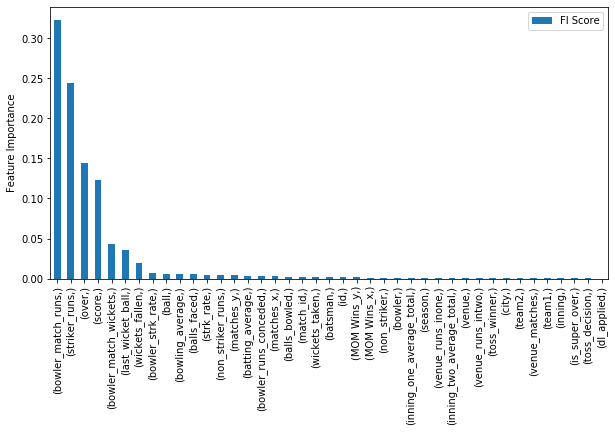

In [55]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=[df_balls_matches_pred.columns],columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)
%matplotlib inline
pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

Text(0, 0.5, 'Feature Importance')

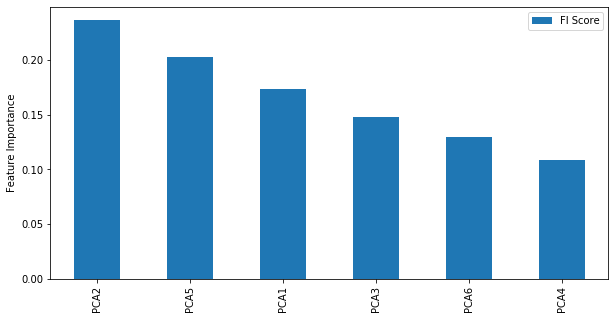

In [60]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X_r,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6'],columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)
%matplotlib inline
pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

In [56]:
gnb = GaussianNB()
dtree = DecisionTreeClassifier()
kNN = KNeighborsClassifier(n_neighbors=3)
folds = 10
models =  [gnb,dtree,kNN]
for m in models:
    cv_results = cross_validate(m, X_r, y, cv= folds,scoring='accuracy', return_train_score=False, verbose = 0, n_jobs = -1)
    print("{} x CV {:22} Accuracy: {:.2f} ".format(folds, type(m).__name__, cv_results['test_score'].mean()))


10 x CV GaussianNB             Accuracy: 0.48 
10 x CV DecisionTreeClassifier Accuracy: 0.49 
10 x CV KNeighborsClassifier   Accuracy: 0.50 


In [58]:
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [59]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

Mean for GNB 0.48
Mean for GNB_bag 0.48
Mean for D-Tree 0.49
Mean for D_Tree_bag 0.51


In [119]:
df_balls_matches_cat = df_balls_matches.copy()
df_balls_matches_cat = df_balls_matches_cat.drop(['dl_applied','toss_winner','toss_decision'], axis=1)
#df_balls_matches_cat.select_dtypes(include=['object']).columns
df_balls_matches_cat.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'result', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

In [122]:
# Trying CatBoostClassifier


cat_features = [4,5,6,17,18,19,20]

y = df_balls_matches_cat['result'].values
X = df_balls_matches_cat.loc[:, df_balls_matches_cat.columns != 'result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_label = y_train
eval_label = y_test


train_dataset = Pool(data=X_train,
                     label=train_label,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_test,
                    label=eval_label,
                    cat_features=cat_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=20,
                           learning_rate=0.50,
                           depth=8,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(eval_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_dataset, 
                          prediction_type='RawFormulaVal')

0:	learn: 1.7462416	total: 2.73s	remaining: 1m 33s
1:	learn: 1.5990951	total: 5.4s	remaining: 1m 29s
2:	learn: 1.5079543	total: 7.95s	remaining: 1m 24s
3:	learn: 1.4398471	total: 10.6s	remaining: 1m 21s
4:	learn: 1.4019276	total: 12.3s	remaining: 1m 13s
5:	learn: 1.3784481	total: 12.7s	remaining: 1m 1s
6:	learn: 1.3532653	total: 15.4s	remaining: 1m 1s
7:	learn: 1.3288940	total: 18.2s	remaining: 1m 1s
8:	learn: 1.3007040	total: 20.8s	remaining: 1m
9:	learn: 1.2906672	total: 23.4s	remaining: 58.6s
10:	learn: 1.2848561	total: 24.5s	remaining: 53.4s
11:	learn: 1.2759523	total: 27.5s	remaining: 52.8s
12:	learn: 1.2600120	total: 30.5s	remaining: 51.6s
13:	learn: 1.2553963	total: 33.4s	remaining: 50.1s
14:	learn: 1.2498719	total: 36.1s	remaining: 48.2s
15:	learn: 1.2430814	total: 38.9s	remaining: 46.2s
16:	learn: 1.2386949	total: 41.5s	remaining: 44s
17:	learn: 1.2354159	total: 44.2s	remaining: 41.8s
18:	learn: 1.2286929	total: 46.9s	remaining: 39.5s
19:	learn: 1.2245914	total: 50.1s	remainin

In [123]:
print('Accuracy : ',accuracy_score(preds_class,y_test),'F1 score:',f1_score(preds_class,y_test,average='macro'))

Accuracy :  0.5210036192102802 F1 score: 0.21348793571083866


In [61]:
dtree1 = DecisionTreeClassifier(criterion='entropy')

adaBoost = AdaBoostClassifier(dtree1,n_estimators=20, algorithm = 'SAMME')
scores_adaBoost = cross_val_score(adaBoost, X_r, y, cv=5, verbose = 0, n_jobs = -1)

scores_adaBoost.mean()

0.491931878387032

In [62]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison.head(5)

,Actual,Predicted
0,O0,O8
1,O0,O1
2,O0,O1
3,O1,O1
4,O0,O1


In [63]:
confusion_matrix(y_test,y_pred)

array([[ 388, 7462,    0,    0,    0,    0,  884],
       [ 466, 8611,    0,    0,    0,    0,  947],
       [   1,    0,    0,    0,    0,    0,    1],
       [   7,   76,    0,    0,    0,    0,    8],
       [   1,   41,    0,    0,    0,    0,    2],
       [   0,    1,    0,    0,    0,    0,    0],
       [   1,    1,    0,    0,    0,    0,    4]], dtype=int64)

# Predicting each over results

In [97]:
df_balls['is_wicket'] = np.where(df_balls['player_dismissed'] == 'NA', 0, 1)

In [130]:
df_balls.is_wicket.value_counts()

0    170244
1      8834
Name: is_wicket, dtype: int64

In [128]:
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,fielder,bowler_runs_conceded,wickets_fallen,score,last_wicket_ball,striker_runs,non_striker_runs,bowler_match_runs,bowler_match_wickets,is_wicket
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,NA,4,0,4,0.0,4,0,4,0,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,4,0.0,4,0,4,0,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,NA,2,0,6,0.0,4,0,6,0,0


In [131]:
df_over = df_balls.groupby(['match_id','over','inning'],as_index=False).agg({'batsman' : lambda x: x.head(1),
                                                              'non_striker' : lambda x: x.head(1),
                                                                   'batting_team' : lambda x: x.head(1),
                                                              'batting_team' : lambda x: x.head(1),
                                                            'bowling_team' : lambda x: x.head(1),
                                                            'bowler' : lambda x: x.head(1),
                                                                   'bowler_runs_conceded' : np.sum,
                                                                   'total_runs' : np.sum,
                                                                   'is_wicket' : np.sum,
                                                             'bowler_match_wickets': lambda x: x.head(1),
                                                             'striker_runs' : lambda x: x.head(1),
                                                             'bowler_match_runs' : lambda x: x.head(1) ,
                                                             'non_striker_runs': lambda x: x.head(1),
                                                             'score' : lambda x: x.head(1),
                                                             'last_wicket_ball' : lambda x: x.head(1)})
# over_bat = df_over['batsman'].str.split(',',expand=True).fillna('NA')
# over_bowl = df_over['bowler'].str.split(',',expand=True).fillna('NA')
# df_over['batsman1'] = over_bat[0]
# df_over['batsman2'] = over_bat[1]
# df_over['batsman3'] = over_bat[2]
# df_over['batsman4'] = over_bat[3]
# df_over['batsman5'] = over_bat[4]
# df_over['bowler1'] = over_bowl[0]
# df_over['bowler2'] = over_bowl[1]
# df_over = df_over.drop(['batsman','bowler'],axis=1)
df_over.head()

,match_id,over,inning,batsman,non_striker,batting_team,bowling_team,bowler,bowler_runs_conceded,total_runs,is_wicket,bowler_match_wickets,striker_runs,bowler_match_runs,non_striker_runs,score,last_wicket_ball
0,1,1,1,DA Warner,S Dhawan,Sunrisers Hyderabad,Royal Challengers Bangalore,TS Mills,6,7,0,0,0,0,0,0,0.0
1,1,1,2,CH Gayle,Mandeep Singh,Royal Challengers Bangalore,Sunrisers Hyderabad,A Nehra,11,11,0,0,17,1,16,0,0.0
2,1,2,1,S Dhawan,DA Warner,Sunrisers Hyderabad,Royal Challengers Bangalore,A Choudhary,16,16,1,0,1,1,4,8,0.0
3,1,2,2,CH Gayle,Mandeep Singh,Royal Challengers Bangalore,Sunrisers Hyderabad,B Kumar,1,1,0,0,17,0,26,10,0.0
4,1,3,1,S Dhawan,MC Henriques,Sunrisers Hyderabad,Royal Challengers Bangalore,TS Mills,6,6,0,0,2,7,4,24,2.5


In [132]:
df_over_ext = df_over.copy()

In [133]:
df_over_ext = df_over_ext.merge(player_data,on='batsman')
df_over_ext = df_over_ext.merge(bowler_data,on='bowler')
df_over_ext = df_over_ext.merge(player_data,left_on='non_striker',right_on='batsman',suffixes=('_str','_nstr'))
df_over_ext.head()

,match_id,over,inning,batsman_str,non_striker,batting_team,bowling_team,bowler,bowler_runs_conceded_x,total_runs,...,MOM Wins_y,balls_bowled,bowler_strk_rate,batsman_nstr,batsman_runs_nstr,matches,MOM Wins,average,balls_faced_nstr,strk_rate_nstr
0,6,1,2,DA Warner,S Dhawan,Sunrisers Hyderabad,Gujarat Lions,SK Raina,3,3,...,14,908,36.32,S Dhawan,4632,158,6,29.316456,3671,126.178153
1,551,9,1,DA Warner,S Dhawan,Sunrisers Hyderabad,Chennai Super Kings,SK Raina,13,13,...,14,908,36.32,S Dhawan,4632,158,6,29.316456,3671,126.178153
2,591,8,2,DA Warner,S Dhawan,Sunrisers Hyderabad,Gujarat Lions,SK Raina,6,6,...,14,908,36.32,S Dhawan,4632,158,6,29.316456,3671,126.178153
3,507,16,2,NV Ojha,S Dhawan,Sunrisers Hyderabad,Chennai Super Kings,SK Raina,9,9,...,14,908,36.32,S Dhawan,4632,158,6,29.316456,3671,126.178153
4,507,18,2,NV Ojha,S Dhawan,Sunrisers Hyderabad,Chennai Super Kings,SK Raina,8,8,...,14,908,36.32,S Dhawan,4632,158,6,29.316456,3671,126.178153


In [134]:
df_over_ext = df_over_ext.drop(['batsman_nstr'],axis=1)
df_over_ext.columns

Index(['match_id', 'over', 'inning', 'batsman_str', 'non_striker',
       'batting_team', 'bowling_team', 'bowler', 'bowler_runs_conceded_x',
       'total_runs', 'is_wicket', 'bowler_match_wickets', 'striker_runs',
       'bowler_match_runs', 'non_striker_runs', 'score', 'last_wicket_ball',
       'batsman_runs_str', 'matches_x', 'MOM Wins_x', 'average_x',
       'balls_faced_str', 'strk_rate_str', 'wickets_taken', 'matches_y',
       'bowler_runs_conceded_y', 'average_y', 'MOM Wins_y', 'balls_bowled',
       'bowler_strk_rate', 'batsman_runs_nstr', 'matches', 'MOM Wins',
       'average', 'balls_faced_nstr', 'strk_rate_nstr'],
      dtype='object')

### Predict runs in each over

In [ ]:
# df_over['result'] = df_over['total_runs'] + (0.1)*df_over['is_wicket']
# df_over = df_over.drop(['total_runs','is_wicket'],axis=1)
# df_over.head()

## If a wicket is going to fall in the over

In [136]:
df_over_wickets = df_over_ext.drop(['total_runs','bowler_runs_conceded_x','bowler_runs_conceded_y'],axis=1)

In [138]:
df_over_wickets.columns

Index(['match_id', 'over', 'inning', 'batsman_str', 'non_striker',
       'batting_team', 'bowling_team', 'bowler', 'is_wicket',
       'bowler_match_wickets', 'striker_runs', 'bowler_match_runs',
       'non_striker_runs', 'score', 'last_wicket_ball', 'batsman_runs_str',
       'matches_x', 'MOM Wins_x', 'average_x', 'balls_faced_str',
       'strk_rate_str', 'wickets_taken', 'matches_y', 'average_y',
       'MOM Wins_y', 'balls_bowled', 'bowler_strk_rate', 'batsman_runs_nstr',
       'matches', 'MOM Wins', 'average', 'balls_faced_nstr', 'strk_rate_nstr'],
      dtype='object')

In [152]:
df_over_en = df_over_wickets.copy()

In [153]:
label_encoder = preprocessing.LabelEncoder()
team_label_encoder = preprocessing.LabelEncoder()
player_label_encoder = preprocessing.LabelEncoder()

team_cols = ['batting_team', 'bowling_team']
team_label_encoder.fit(pd.DataFrame(allteams_unique))
for t in team_cols:
    df_over_en[t] = team_label_encoder.transform(df_over_en[t])

player_cols = ['batsman_str', 'non_striker', 'bowler']
player_label_encoder.fit(pd.DataFrame(allplayers_unique))
for p in player_cols:
    df_over_en[p] = player_label_encoder.transform(df_over_en[p])

df_over_en.head()

,match_id,over,inning,batsman_str,non_striker,batting_team,bowling_team,bowler,is_wicket,bowler_match_wickets,...,average_y,MOM Wins_y,balls_bowled,bowler_strk_rate,batsman_runs_nstr,matches,MOM Wins,average,balls_faced_nstr,strk_rate_nstr
0,6,1,2,121,423,14,4,462,0,0,...,44.72,14,908,36.32,4632,158,6,29.316456,3671,126.178153
1,551,9,1,121,423,14,0,462,1,1,...,44.72,14,908,36.32,4632,158,6,29.316456,3671,126.178153
2,591,8,2,121,423,14,4,462,0,0,...,44.72,14,908,36.32,4632,158,6,29.316456,3671,126.178153
3,507,16,2,339,423,14,0,462,0,0,...,44.72,14,908,36.32,4632,158,6,29.316456,3671,126.178153
4,507,18,2,339,423,14,0,462,1,0,...,44.72,14,908,36.32,4632,158,6,29.316456,3671,126.178153


We set the label class as 'is_wicket' to 0 if no wicket falls, and 1 if any wicket falls. (Making this a binary classification task)

In [154]:
df_over_en['is_wicket'] = np.where(df_over_en['is_wicket'] == 0, 0, 1)

In [155]:
df_over_en['is_wicket'].value_counts()

0    13142
1     4601
Name: is_wicket, dtype: int64

In [142]:
y = df_over_en['is_wicket'].values
X = df_over_en.loc[:, df_over_en.columns != 'is_wicket'].values

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_pred,y_test),'F1 score:',f1_score(y_pred,y_test,average='macro'))

Accuracy :  0.6973795435333897 F1 score: 0.59823624003292


In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=df_over_en.columns,columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)
%matplotlib inline
pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

### PCA for over data

In [145]:
# Scale input features to N(0,1)
X_scal = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
X_r = pca.fit(X_scal).transform(X)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_pred,y_test),'F1 score:',f1_score(y_pred,y_test,average='macro'))

Accuracy :  0.7416173570019724 F1 score: 0.4342030391458889


Accuracy increased after PCA and normalisation

In [147]:
dtree = DecisionTreeClassifier()
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [148]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

Mean for GNB 0.74
Mean for GNB_bag 0.74
Mean for D-Tree 0.57
Mean for D_Tree_bag 0.67


In [149]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison['Actual'].value_counts()

0    2629
1     920
Name: Actual, dtype: int64

In [150]:
display_comparison['Predicted'].value_counts()

0    3536
1      13
Name: Predicted, dtype: int64

## We are only predicting the majority class!!!

Using Upsampling we can bring the number of samples for both classes to equal number and then try to predict.

In [157]:
wicket_0 = df_over_en[df_over_en.is_wicket == 0]
wicket_1 = df_over_en[df_over_en.is_wicket == 1]
wicket_1 = resample(wicket_1,replace=True,n_samples=13142) #making minority samples equal to majority
upsampled_df = pd.concat([wicket_0, wicket_1])

In [169]:
upsampled_df.columns

Index(['match_id', 'over', 'inning', 'batsman_str', 'non_striker',
       'batting_team', 'bowling_team', 'bowler', 'bowler_match_wickets',
       'striker_runs', 'bowler_match_runs', 'non_striker_runs', 'score',
       'last_wicket_ball', 'batsman_runs_str', 'matches_x', 'MOM Wins_x',
       'average_x', 'balls_faced_str', 'strk_rate_str', 'wickets_taken',
       'matches_y', 'average_y', 'MOM Wins_y', 'balls_bowled',
       'bowler_strk_rate', 'batsman_runs_nstr', 'matches', 'MOM Wins',
       'average', 'balls_faced_nstr', 'strk_rate_nstr'],
      dtype='object')

In [158]:
y = upsampled_df['is_wicket'].values
X = upsampled_df.loc[:, upsampled_df.columns != 'is_wicket'].values

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_pred,y_test),'F1 score:',f1_score(y_pred,y_test,average='macro'))

Accuracy :  0.5891192695453681 F1 score: 0.5869725198316568


In [162]:
dtree = DecisionTreeClassifier()
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [166]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

Mean for GNB 0.55
Mean for GNB_bag 0.55
Mean for D-Tree 0.62
Mean for D_Tree_bag 0.61


In [164]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison['Actual'].value_counts()

1    2680
0    2577
Name: Actual, dtype: int64

In [165]:
display_comparison['Predicted'].value_counts()

0    2805
1    2452
Name: Predicted, dtype: int64

## Predicting the score of each match

In [124]:
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,fielder,bowler_runs_conceded,wickets_fallen,score,last_wicket_ball,striker_runs,non_striker_runs,bowler_match_runs,bowler_match_wickets,is_wicket
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,0,0.0,0,0,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,NA,4,0,4,0.0,4,0,4,0,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,NA,0,0,4,0.0,4,0,4,0,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,NA,2,0,6,0.0,4,0,6,0,0


In [125]:
bat_first_data = df_balls[df_balls['inning'] == 1]
bat_scnd_data = df_balls[df_balls['inning'] == 1]
df_total_score = bat_first_data.groupby(['match_id','batting_team', 'bowling_team'],as_index=False)['total_runs'].sum()

In [126]:
df_total_score.head()

,match_id,batting_team,bowling_team,total_runs
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,207
1,2,Mumbai Indians,Rising Pune Supergiant,184
2,3,Gujarat Lions,Kolkata Knight Riders,183
3,4,Rising Pune Supergiant,Kings XI Punjab,163
4,5,Royal Challengers Bangalore,Delhi Daredevils,157


In [ ]:
df_total_score = df_total_score.merge(df_matches[['id','team1','team2','venue']],left_on='match_id',right_on='id')
df_total_score.head()

In [ ]:
#df_total_score = pd.concat([df_total_score,pd.get_dummies(df_total_score[['team1_x','team2_x','venue']])],axis=1)

In [ ]:

  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
cols = ['batting_team','bowling_team','team1','team2','venue']
for c in cols:
    df_total_score[c] = label_encoder.fit_transform(df_total_score[c])
df_total_score.head()

In [ ]:
df_total_score_norm = df_total_score.drop(['batting_team','bowling_team'], axis=1)

In [ ]:
interval_range = pd.interval_range(start=0, freq=10, end=280)
df_total_score['target_range'] = pd.cut(df_total_score['total_runs'], bins=interval_range)
df_total_score.head()

In [ ]:
df_total_score_norm.head()

In [ ]:
categorical_features = df_total_score_norm.select_dtypes(include=['object']).columns
categorical_features

In [ ]:
from sklearn.linear_model import LinearRegression
y = df_total_score_norm['total_runs']
X = df_total_score_norm.drop('total_runs', axis=1)

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]
for encoder in encoder_list:
    
    preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=500))])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(encoder)
    print(f1_score(y_test, y_pred, average='macro'))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) 
lr = LinearRegression()
y_pred = lr.fit(X_train,y_train).predict(X_test)

In [ ]:
comp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comp.head()